# Analysis of the results

In [1]:
import numpy as np
import os
import csv
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from PIL import Image

In [166]:
def get_queries(fname):
    queries = {}
    with open(fname, "r") as f:
        for line in f:
            liste = line.split("),(")
            key, liste[0] = liste[0].split(",(")
            liste[-1] = liste[-1][:-2]
            for i in range(len(liste)):
                tmp = liste[i].split(",")
                liste[i] = (int(tmp[0]), float(tmp[1]), int(float(tmp[2])))
            queries[int(key)] = sorted(liste, key=lambda x: x[1], reverse=True)
    return queries

In [167]:
fname = "../results/queries_class.txt"

queries_class = get_queries(fname)
queries_regressor = get_queries("../results/queries_regressor.txt")

In [168]:
def get_AP(scores):
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    p_nom = 0
    p_div = 0
    cum_sum = 0
    nb_rel = 0
    for s in sorted_scores:
        p_div += 1
        if s[2] == 1:
            p_nom += 1
        if s[2] == 1:
            cum_sum += p_nom * 1. / max(1, p_div)
            nb_rel += 1
    return cum_sum, nb_rel

def get_map(queries):
    mAP = 0
    Q = 0
    for q in queries.keys():
        cum_sum, nb_rel = get_AP(queries[q])
        score = cum_sum * 1. / max(1, nb_rel)
        if nb_rel > 0:
            mAP += score
            Q += 1
    mAP /= max(1, Q)
    return mAP

def get_weighted_map(queries):
    mAP = 0
    Q = 0
    for q in queries.keys():
        cum_sum, nb_rel = get_AP(queries[q])
        score = cum_sum
        if nb_rel > 0:
            mAP += score
            Q += nb_rel
    mAP /= max(1, Q)
    return mAP

In [169]:
def get_fusion(query1, query2, fusion=lambda x, y: (x + y)/2):
    query = {}
    for key in query1.keys():
        scores1 = query1[key]
        if key not in query2.keys():
            print("Warning: query2 does not contain key {}".format(key))
            continue
        scores2 = {elt[0]: elt[1] for elt in query2[key]}
        scores = []
        for elt in scores1:
            if elt[0] not in scores2.keys():
                print("Warning: query1 and query2 do not have same keys")
                continue
            s2 = scores2[elt[0]]
            scores.append((elt[0], fusion(elt[1], s2), elt[2]))
        query[key] = sorted(scores, key=lambda x: x[1], reverse=True) 
    return query

In [170]:
queries_fusion = get_fusion(queries_class, queries_regressor, fusion=lambda x, y: (x + y) / 2)

In [171]:
print(get_weighted_map(queries_fusion))

0.912023561074167


In [56]:
plt.rcParams.update({'font.size': 22})

In [252]:
def plot_queries(words_list, queries, first_bests=3):
    words = len(words_list)
    nquerries = len(list(queries.keys()))
    res = len(list(queries.values())[0])
    
    for i, qr in enumerate(words_list):
        idx, score, pair = queries[qr][0]
        nb_rel = np.sum([elt[2] for elt in queries[qr]])
        plt.subplot(words, first_bests+1, 1 + i*(first_bests+1))
        im = Image.open('../dataset/word-{:06d}.png'.format(int(qr)))
        plt.imshow(im)
        plt.axis('off')
        plt.title('Query word \n(nb: {})'.format(nb_rel))

        plt.subplot(words, first_bests+1, 2 + i*(first_bests+1))
        im = Image.open('../dataset/word-{:06d}.png'.format(int(idx)))
        plt.imshow(im)
        plt.axis('off')
        plt.title(('True' if int(pair) == 1 else 'False') + '\nScore : {:.3f}'.format(float(score)))
        for j in range(first_bests-1):
            idx, score, pair = queries[qr][j + 1]
            plt.subplot(words, first_bests+1, 3 + j + i*(first_bests+1))
            im = Image.open('../dataset/word-{:06d}.png'.format(int(idx)))
            plt.imshow(im)
            plt.axis('off')
            plt.title(('True' if int(pair) == 1 else 'False') + '\nScore : {:.3f}'.format(float(score)))


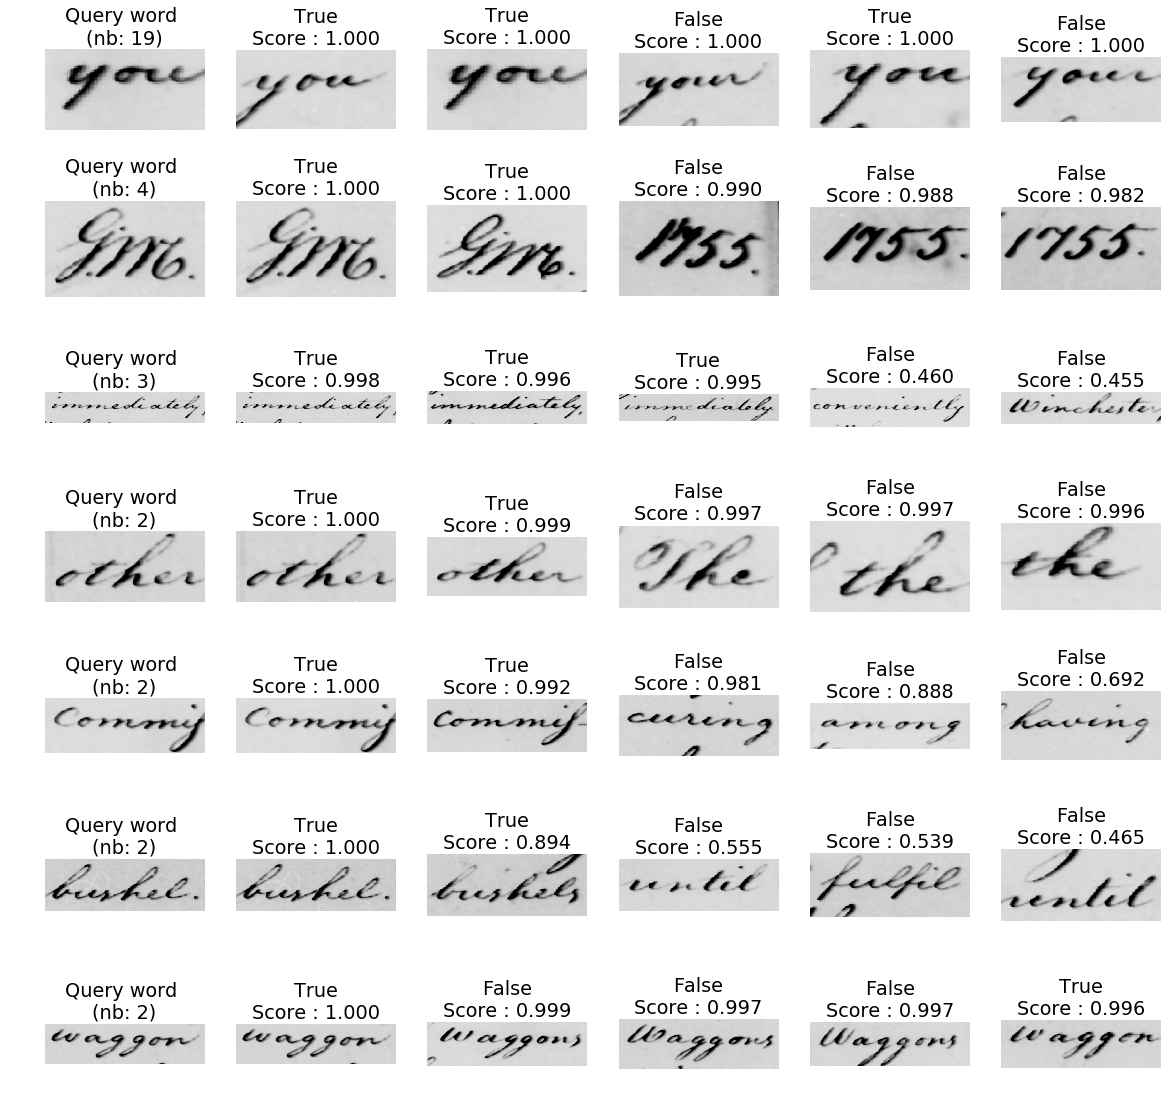

In [255]:
queries = queries_fusion
chosen = [4263, 4288, 4037, 3722, 3809, 3938, 4837]


words = 5
first_bests = 3
nquerries = len(list(queries.keys()))
res = len(list(queries.values())[0])

plt.figure(figsize=(20,20))

keys = list(queries.keys())

np.random.shuffle(keys)
plot_queries(chosen, queries_fusion, first_bests=5)
#plt.savefig("queries.png", dpi=300)
plt.show()

In [203]:
curves = np.loadtxt("../results/scores.csv", delimiter=',')
plt.rcParams.update({'font.size': 16})

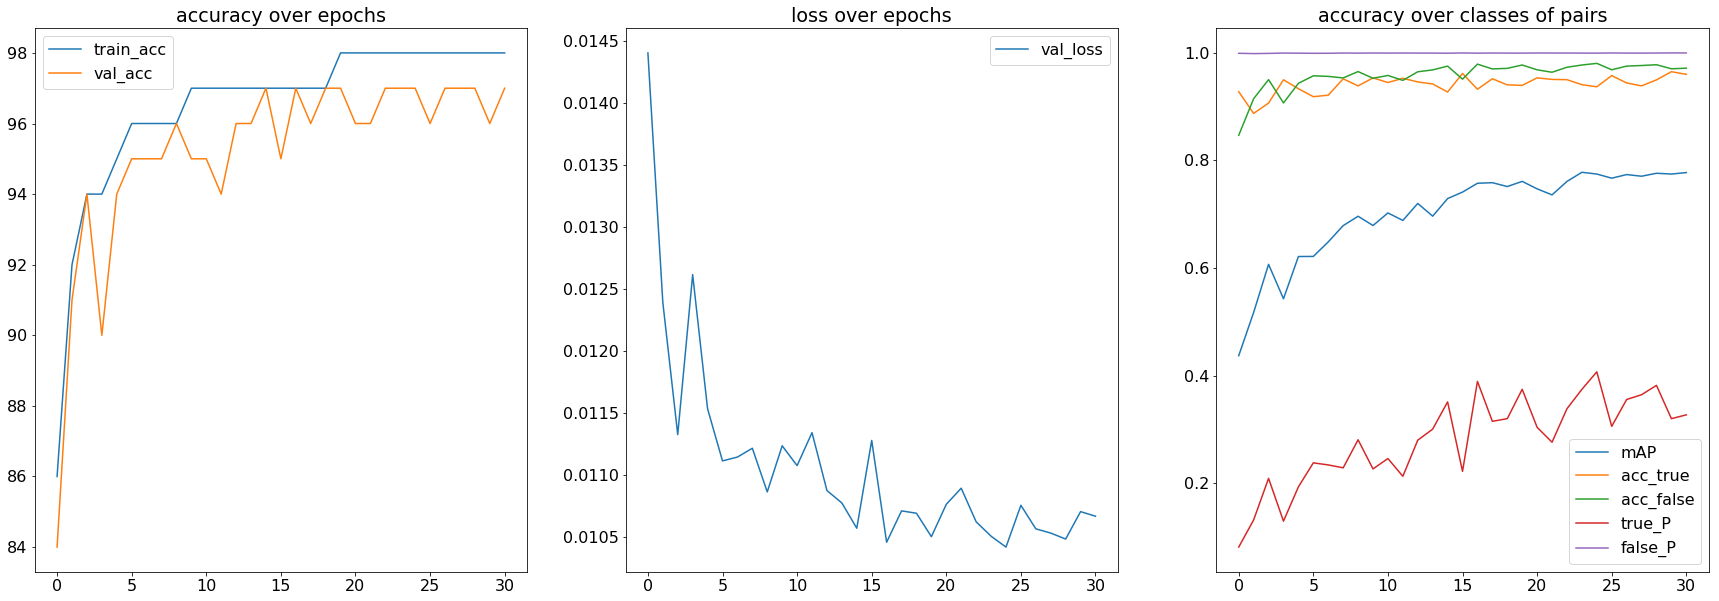

In [202]:
labels = ['train_acc', 'val_acc', 'val_loss', 'time', 'mAP', 'acc_true', 'acc_false', 'true_P', 'false_P']
plt.figure(figsize = (30,10))
plt.subplot(131)
plt.plot(curves[:,0], label = labels[0])
plt.plot(curves[:,1], label = labels[1])
plt.title('accuracy over epochs')
plt.legend()

plt.subplot(132)
plt.plot(curves[:,2], label = labels[2])
plt.title('loss over epochs')
plt.legend()

plt.subplot(133)
for i in range(5):
    plt.plot(curves[:,4+i], label = labels[4+i])
plt.title('accuracy over classes of pairs')
plt.legend()
plt.savefig("curves.png", dpi=300)
plt.show()

# mAP according to word length

In [187]:
words = []

with open("../dataset/words.txt", "r") as f:
    words = [line.strip() for line in f]

In [188]:
def get_length_hist(queries, words):
    max_length = max([len(w) for w in words])

    hist = [0 for i in range(max_length + 1)]
    counters = [0 for i in range(max_length + 1)]

    for key in queries.keys():
        idx = len(words[key])
        score, nb_rel = get_AP(queries[key])
        if nb_rel > 0:
            hist[idx] += score / nb_rel
            counters[idx] += 1
    return [hist[i] / max(1, counters[i]) for i in range(len(hist))], counters

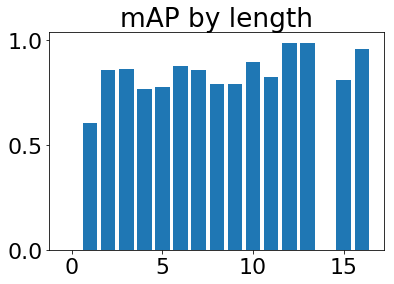

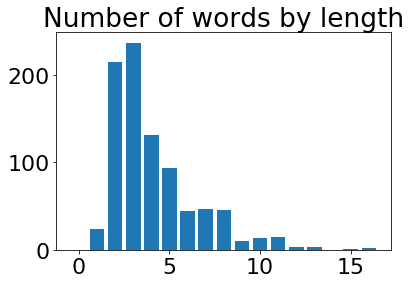

In [195]:
hist_fusion, counters = get_length_hist(queries_fusion, words)

plt.bar([i for i in range(len(hist_fusion))], hist_fusion)
plt.title("mAP by length")
plt.show()
plt.bar([i for i in range(len(hist_fusion))], counters)
plt.title("Number of words by length")
plt.show()

## mAP according to word frequency

In [120]:
def get_freq_hist(queries, words, maxi=75):
    hist = [0 for i in range(maxi)]
    counters = [0 for i in range(maxi)]

    for key in queries.keys():
        score, nb_rel = get_AP(queries[key])
        if nb_rel > 0 and nb_rel < maxi:
            idx = nb_rel
            hist[idx] += score / nb_rel
            counters[idx] += 1
    return [hist[i] / max(1, counters[i]) for i in range(len(hist))], counters

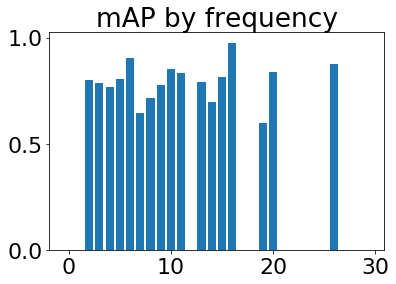

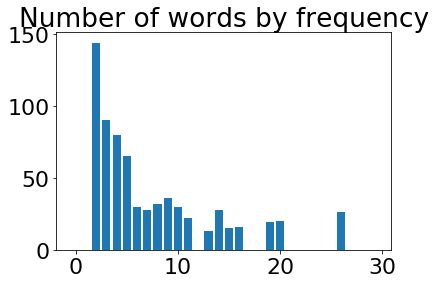

In [126]:
hist_fusion, counters = get_freq_hist(queries_fusion, words, maxi=30)
hist_class, counters = get_freq_hist(queries_class, words, maxi=30)
hist_regressor, counters = get_freq_hist(queries_regressor, words, maxi=30)

plt.bar([i for i in range(len(hist_fusion))], hist_fusion)
plt.title("mAP by frequency")
plt.show()
plt.bar([i for i in range(len(hist_fusion))], counters)
plt.title("Number of words by frequency")
plt.show()

## Score evolution for a query

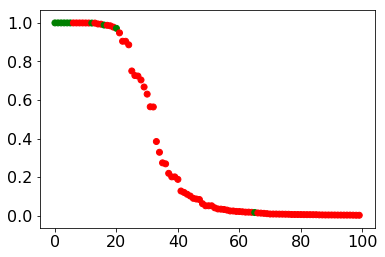

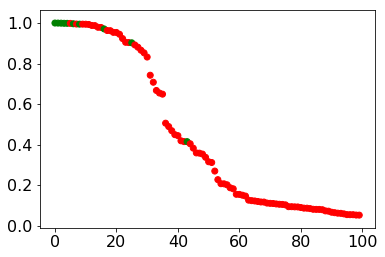

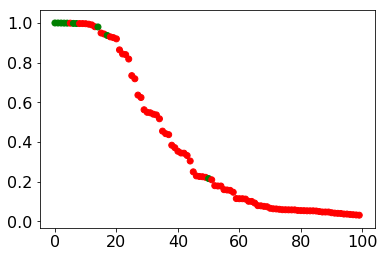

In [254]:
q = 4654# the: 4191 #Alexandria : 4654 # 4047 : W # 3893: Fort
maxi = 100
scores_class = queries_class[q][:maxi]
scores_regressor = queries_regressor[q][:maxi]
scores_fusion = queries_fusion[q][:maxi]

blue = "green"
red = "red"

y_class = [elt[1] for elt in scores_class]
y_regressor = [elt[1] for elt in scores_regressor]
y_fusion = [elt[1] for elt in scores_fusion]
c_class = [blue if elt[2] == 1 else red for elt in scores_class]
c_regressor = [blue if elt[2] == 1 else red for elt in scores_regressor]
c_fusion = [blue if elt[2] == 1 else red for elt in scores_fusion]

plt.scatter(range(len(y_class)), y_class, color=c_class)
plt.show()
plt.scatter(range(len(y_class)), y_regressor, color=c_regressor)
plt.show()
plt.scatter(range(len(y_class)), y_fusion, color=c_fusion)
plt.show()


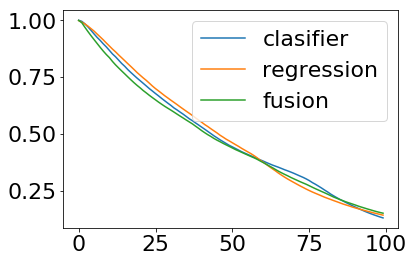

In [184]:
maxi=100
scores_class = np.zeros((maxi,))
scores_regression = np.zeros((maxi,))
scores_fusion = np.zeros((maxi,))

n = 0

for q in queries_class.keys():
    scores_class += np.array([elt[1] for elt in queries_class[q][:maxi]])
    scores_regression += np.array([elt[1] for elt in queries_regressor[q][:maxi]])
    scores_fusion += np.array([elt[1] for elt in queries_fusion[q][:maxi]])
    n += 1
scores_class /= n
scores_regression /= n
scores_fusion /= n

plt.plot(scores_class, label="clasifier")
plt.plot(scores_regression, label="regression")
plt.plot(scores_fusion, label="fusion")
plt.legend()
plt.show()

## mAP for new words

In [234]:
import os, re

string_transform = {
    "strict": lambda w: w,
    "lower": lambda w: w.lower(),
    "ponctuation": lambda w: re.sub("[^\w\s]", "", w),
    "all": lambda w: re.sub("[^\w\s]", "", w).lower()
}

transf = string_transform["ponctuation"]

words = []

with open("../dataset/words.txt", "r") as f:
    words = [transf(line.strip()) for line in f]

new = []
redondant_new = set()

for i, elt in enumerate(words[3697:]):
    idx = i + 3697
    if elt not in words[:3697]:
        if elt in new:
            redondant_new.add(elt)
        new.append(elt)
        
redondant_idx = []
for i, elt in enumerate(words):
    if elt in redondant_new:
        redondant_idx.append(i)

In [235]:
print("number of queries of words that don't appear in training set: {}".format(len(redondant_idx)))

number of queries of words that don't appear in training set: 46


In [236]:
matches = np.loadtxt("../results/queries.txt", delimiter='),(', dtype=str)
queries = {}
mAP = 0
Q = 0
for i in range(matches.shape[0]):
    q, first = matches[i][0].split(",(")
    q = int(q)
    if q in redondant_idx:
        scores = [(int(first.split(",")[0]), float(first.split(",")[1]), int(first.split(",")[2]))]
        scores += [(int(elt.split(",")[0]), float(elt.split(",")[1]), int(elt.split(",")[2])) for elt in matches[i][1:-1]]
        last = matches[i][-1]
        scores.append((int(last.split(",")[0]), float(last.split(",")[1]), int(last.split(",")[2][:-1])))
        queries[q] = scores
        p_nom = 0
        p_div = 0
        cum_sum = 0
        nb_rel = 0
        for s in scores:
            if s[1] >= 0.5:
                p_div += 1
                if s[2] == 1:
                    p_nom += 1
            if s[2] == 1:
                cum_sum += p_nom * 1. / max(1, p_div)
                nb_rel += 1
        score = cum_sum * 1. / max(1, nb_rel)
        if nb_rel > 0:
            mAP += score
            Q += 1
mAP /= max(1, Q)
print("mAP: {}".format(mAP))

mAP: 0.5977790946944918


In [237]:
redondant_new_simple = redondant_new - set([
    '10th',
    '11th',
    '16th',
    '20th',
    '22d',
    '8th'
])

In [238]:
redondant_idx_simple = []
for i, elt in enumerate(words):
    if elt in redondant_new_simple:
        redondant_idx_simple.append(i)

In [239]:
len(redondant_idx_simple)

29

In [240]:
queries = {}
mAP = 0
Q = 0
for i in range(matches.shape[0]):
    q, first = matches[i][0].split(",(")
    q = int(q)
    if q in redondant_idx_simple:
        scores = [(int(first.split(",")[0]), float(first.split(",")[1]), int(first.split(",")[2]))]
        scores += [(int(elt.split(",")[0]), float(elt.split(",")[1]), int(elt.split(",")[2])) for elt in matches[i][1:-1]]
        last = matches[i][-1]
        scores.append((int(last.split(",")[0]), float(last.split(",")[1]), int(last.split(",")[2][:-1])))
        queries[q] = scores
        p_nom = 0
        p_div = 0
        cum_sum = 0
        nb_rel = 0
        for s in scores:
            if s[1] >= 0.5:
                p_div += 1
                if s[2] == 1:
                    p_nom += 1
            if s[2] == 1:
                cum_sum += p_nom * 1. / max(1, p_div)
                nb_rel += 1
        score = cum_sum * 1. / max(1, nb_rel)
        if nb_rel > 0:
            mAP += score
            Q += 1
mAP /= max(1, Q)
print("mAP: {}".format(mAP))

mAP: 0.7273858549846107


In [242]:
redondant_new

{'10th',
 '11th',
 '16th',
 '20th',
 '22d',
 '8th',
 'Chest',
 'Gist',
 'Pray',
 'So',
 'bushel',
 'charge',
 'commis',
 'kept',
 'over',
 'party',
 'procure',
 'town',
 'waggon'}

In [243]:
redondant_idx_simple

[3729,
 3809,
 3835,
 3865,
 3938,
 3941,
 3946,
 3991,
 4090,
 4099,
 4113,
 4170,
 4196,
 4205,
 4206,
 4219,
 4256,
 4310,
 4355,
 4379,
 4412,
 4425,
 4492,
 4493,
 4572,
 4596,
 4735,
 4796,
 4837]